**Лабораторный практикум по курсу «Распознавание диктора», Университет ИТМО, 2025**		

**Лабораторная работа №7. Дикторская диаризация: «кто и когда говорит?»**

**Цель работы:** изучение базового алгоритма дикторской диаризации для разделения речевого сигнала на участки речи, содержащие голос только одного диктора.

**Краткое описание**: в рамках настоящей лабораторной работы необходимо познакомиться с базовой реализацией алгоритма дикторской диаризации через решение задачи кластеризации дикторских моделей, вычисленных в скользящем окне фиксированного размера. В работе предлагается создать синтетический речевой сигнал, содержащий непересекающуюся речь нескольких дикторов, вычислить локальные дикторские эмбеддинги сигнала, кластеризовав их, и сформировать разметку, содержащую информацию о том, в какие моменты времени звучат голоса отдельных дикторов. Итогом выполнения работы является визуальная и численная оценка ошибки диаризации, возникшей в ходе работы алгоритма.

**Данные**: в качестве данных для выполнения лабораторной работы предлагается использовать тестовую часть базы [VoxCeleb1](http://www.robots.ox.ac.uk/~vgg/data/voxceleb/vox1.html).

**Содержание лабораторной работы**

1. Подготовка синтетической аудиозаписи для проведения экспериментов.

2. Вычисление локальных дикторских эмбеддингов.

3. Кластеризация вычисленных эмбеддингов.

4. Формирование разметки диаризации, полученной алгоритмом.

5. Оценка ошибки алгоритма дикторской диаризации для разных настроек.

In [1]:
# IPython extension to reload modules before executing user code
%load_ext autoreload
%autoreload 2

import os
import sys
import random

sys.path.append(os.path.realpath('..'))

import numpy as np
import torch
import torchaudio
import pandas as pd

from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering, DBSCAN
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
import IPython.display as ipd

from ResNetSE34V2 import MainModel
from LoadModel import load_model
from common import download_dataset, extract_dataset

**1. Подготовка данных для анализа**

В ходе выполнения лабораторной работы необходимы данные для осуществления процедуры тестирования алгоритма дикторской диаризации. Возьмём в качестве этих данных несколько звукозаписей голосов людей мужского и женского пола, сохраненных в формат *wav*, выбранных из корпуса [VoxCeleb1 test set](https://thor.robots.ox.ac.uk/~vgg/data/voxceleb/vox1a/vox1_test_wav.zip). Данный корпус содержит 4,874 звукозаписи (частота дискретизации равна 16кГц) 40 дикторов мужского и женского пола, разговаривающих на английском языке.

В рамках настоящего пункта требуется выполнить загрузку и распаковку звуковых wav-файлов из корпуса VoxCeleb1 test set.

![Рисунок 1](https://analyticsindiamag.com/wp-content/uploads/2020/12/image.png "VoxCeleb. Крупномасштабная аудиовизуальная база данных человеческой речи.")

In [2]:
# Download VoxCeleb1 (test set)
with open('../data/lists/datasets.txt', 'r') as f:
    lines = f.readlines()

download_dataset(lines, user='voxceleb1902', password='nx0bl2v2', save_path='../data')

Checksum successful vox1_test_wav.zip.


In [3]:
# Extract VoxCeleb1 test set
extract_dataset(save_path='../data/voxceleb1_test', fname='../data/vox1_test_wav.zip')

Extracting of ../data/vox1_test_wav.zip is successful.


**2. Устройство алгоритма дикторской диаризации**

*Дикторская диаризация* – это процедура, позволяющая выполнить разделение речевого сигнала на сегменты, в которых звучит голос только одного диктора, присутствующего в записи. При этом каждому сегменту назначается некоторая абстрактная метка диктора, являющаяся общей для всех сегментов, в которых звучит голос одного и того же диктора. Необходимо отметить, что дикторская диаризация является важнейшим элементом пайплайна системы голосовой биометрии в случае, если в анализируемом аудио присутствуют одновременно голоса нескольких дикторов. Отсутствие дикторской диаризации в указанном случае будет приводить к тому, что при построении дикторской модели для мультиспикерной записи будет вычисляться некоторая усреднённая по нескольким дикторам модель. Последнее будет приводить к некорректной работе биометрической системы, например, в режиме верификации, когда усреднённая по нескольким дикторам тестовая модель будет сравниваться с уникальным эталоном конкретного диктора.

На данный момент существует [множество подходов](https://arxiv.org/pdf/2101.09624) к решению задачи дикторской диаризации. В рамках настоящей лабораторной работы рассматриваеся [классическая схема диаризационного конвейера](https://www.danielpovey.com/files/2019_icassp_multi_speaker.pdf), основанная на использовании процедуры кластеризации дикторских эмбеддингов, вычисленных для локальных участков обрабатываемого сигнала. Основными этапами данной схемы являются следующие:

1. **Вычисление разметки детектора речи.** На данном этапе происходит определение областей сигнала, в которых присутствует речь (в настоящей лабораторной работе не используется в предположении, что речевой сигнал содержит паузы минимальной длины).

2. **Сегментация речевых участков** подразумевает разбиение речевых фрагментов на кусочки небольшого размера с помощью скользящего окна, имеющего определённый размер, например, 1.5 секунды, и перемещающегося вдоль речевого участка с некоторым шагом, как правило, равным половине длины окна.

3. **Вычисление локальных дикторских эмбеддингов** осуществляется с помощью, как правило, нейросетевой модели, позволяющей на основе куска речевого сигнала, находящегося в пределах скользящего окна, вычислить дикторский эмбеддинг. Количество вычисленных дикторских эмбеддингов в рамках одного аудио напрямую зависит от его длины. Чем больше длина аудио, тем, вероятно, больше речевых участков в нём и больше эмбеддингов будет рассчитано. Последнее является важным, как с точки зрения вычислительной стоимости алгоритма, так и с точки зрения объёма статистических данных, необходимых для разделения анализируемой записи на кусочки, однородные в смысле дикторских признаков.

4. **Кластеризация локальных дикторских эмбеддингов.** На данном этапе при помощи общеизвестных алгоритмов кластеризации, [k-средних](https://en.wikipedia.org/wiki/K-means_clustering) (k-means), [агломеративной иерархической кластеризации](https://en.wikipedia.org/wiki/Hierarchical_clustering) (AHC, agglomerative hierarchical clustering), [спектральной кластеризации](https://en.wikipedia.org/wiki/Spectral_clustering) (spectral clustering), [основанной на плотности пространственной кластеризации для приложений с шумами](https://en.wikipedia.org/wiki/DBSCAN) (DBSCAN, density-based spatial clustering of applications with noise) и т.п., осуществляется разбиение локальных дикторских эмбеддингов на кластеры, каждый из которых будет связан с определённым диктором. Важно отметить, что некоторые из алгоритмов кластеризации, например, k-средних, требуют задания числа кластеров или, фактически, числа дикторов, голоса которых звучат в анализируемом аудио. В реальных практических задачах в подобной ситуации требуется специальным образом [оценить число кластеров](https://www.sciencedirect.com/science/article/pii/0377042787901257), если оно не является известным заранее (в рамках настоящей лабораторной работы число кластеров предполагается известным для простоты).

5. **Формирование диаризационной разметки во временной области** предполагает преобразование результата кластеризации эмбеддингов в разметку алгоритма дикторской диаризации, представленную во временной области. Формирование данной разметки происходит с учётом метки кластера, к которому был отнесён эмбеддинг, и позиции скользящего окна, для которого он был вычислен. Результат работы алгоритма диаризации может быть сохранён в виде *файла расширенной транскрипции с метками времени* (RTTM, rich transcription time marked).

Ниже представлена последовательность действий, которую необходимо выполнить при рассмотрении настоящего пункта:

1. Сконфигурировать настройки рассматриваемого эксперимента.

2. Подготовить одну синтетическую аудиозапись для проведения экспериментов с эталонной разметкой, содержащей информацию о том, в каких речевых сегментах звучат голоса одиночных дикторов.

3. Выполнить разбиение обрабатываемого аудио с помощью скользящего окна и вычислить локальные дикторские эмбеддинги для рассмотренных позиций скользящего окна.

4. Осуществить кластеризацию полученных эмбеддингов.

5. Сформировать итоговую разметку диаризации, полученную алгоритмически, и вычислить *диаризационное ошибку* (DER, diarization error rate), описывающую расхождение между эталонной разметкой диаризации, и разметкой, полученной алгоритмически.

**2.1. Конфигурирование настроек эксперимента.** Вначале необходимо выбрать настройки проводимого эксперимента, связанные с выбором параметров скользящего окна, алгоритма кластеризации и его параметров, и т.п. 

In [4]:
# Audio and sliding window settings
SAMPLE_RATE = 16000                                  # sampling rate
WINDOW_SEC  = 2.0                                    # window size, sec
STEP_SEC    = 0.5                                    # window step, sec 

# Clustering algorithm configuration
CLUSTER_ALGO = 'agglo'                               # 'kmeans', 'agglo', 'spectral', 'dbscan'
N_SPEAKERS   = 3                                     # for 'kmeans'/'agglo'/'spectral' and generating a synthetic audio
DBSCAN_EPS   = 0.6                                   # for 'dbscan'
DBSCAN_MIN_SAMPLES = 5                               # for 'dbscan'

# Settings for generating synthetic data
SYNTH_OUTPUT = 'synth_audio_example/synth_audio.wav' # path to output audio
TURN_SEC = 3.0                                       # approximate length of speech segments, sec
N_TURNS_PER_SPK = 3                                  # number of speech segments per speaker

**2.2. Генерация синтетической записи с эталонной дикторской разметкой.** Для начала, давайте, сгенерируем одну синтетическую запись, содержащую искусственную склейку неналоженных голосов нескольких дикторов. Для генерации аудио выберем случайно несколько произнесений разных дикторов из данных  VoxCeleb1 test set и соедим их в одно аудио, разделяя небольшими паузами.

In [5]:
random.seed(42)

def list_voxceleb_utts(base_path):
    # Function for creating a dictionary of "speaker label: a list of utterances of this speaker"
    
    spk2utts = {}
    for spk in os.listdir(base_path):
        
        spk_dir = os.path.join(base_path, spk)
        if not os.path.isdir(spk_dir):
            continue
        
        files = []
        for root, _, fnames in os.walk(spk_dir):
            
            for fn in fnames:
                
                if fn.endswith('.wav'):
                    files.append(os.path.join(root, fn))
        
        if len(files) > 0:
            spk2utts[spk] = files
    
    return spk2utts

segments_ref = None

base_path = '../data/voxceleb1_test/wav'
spk2utts = list_voxceleb_utts(base_path)

assert len(spk2utts) >= 2, 'A minimum of two speakers are needed from VoxCeleb1 test set.'

# Randomly selecting speech samples to create synthetic audio
chosen_spks = random.sample(list(spk2utts.keys()), N_SPEAKERS)
turns = []
labels = []
sil = torch.zeros(int(0.2*SAMPLE_RATE)) # a short pause between speech segments
for turn_idx in range(N_TURNS_PER_SPK):
    
    for lab, spk in enumerate(chosen_spks):
        utt_path = random.choice(spk2utts[spk])
        wav, sr = torchaudio.load(utt_path)
        
        if sr != SAMPLE_RATE:
            wav = torchaudio.functional.resample(wav, sr, SAMPLE_RATE)
        
        wav = wav.mean(dim=0, keepdim=False)
        L = int(TURN_SEC * SAMPLE_RATE)
        if wav.numel() < L:
            reps = int(np.ceil(L/wav.numel()))
            wav = wav.tile(reps)[:L]
        
        else:
            st = random.randint(0, wav.numel() - L)
            wav = wav[st:st + L]
        
        turns.append(wav)
        labels.append(lab)
        turns.append(sil)
        labels.append(-1)

# Concatenation of selected speech segments into the final audio
mixture = torch.cat(turns)
t = 0
segments_ref = []
for idx, seg in enumerate(turns):
    dur = seg.numel()/SAMPLE_RATE
    
    if labels[idx] >= 0:
        segments_ref.append((t, t + dur, labels[idx]))
    
    t += dur

os.makedirs(os.path.dirname(SYNTH_OUTPUT), exist_ok=True)
torchaudio.save(SYNTH_OUTPUT, mixture.unsqueeze(0), SAMPLE_RATE)

# Generating RTTM file with reference diarization markup
rec_id = os.path.splitext(os.path.basename(SYNTH_OUTPUT))[0]
rttm_lines = []
for s, e, lab in segments_ref:
    dur = max(0.0, e - s)
    rttm_lines.append(f'SPEAKER {rec_id} 1 {s:.3f} {dur:.3f} <NA> <NA> speaker_{lab} <NA> <NA>')

with open(SYNTH_OUTPUT.replace('.wav', '_ref.rttm'), 'w') as f:
    f.write('\n'.join(rttm_lines))

AUDIO_PATH = SYNTH_OUTPUT

**2.3. Разбиение обрабатываемого аудио с помощью скользящего окна.** На данном этапе необходимо, используя скользящее окно, сформировать набор сегментов, по отношению к которым будут вычислены локальные эмбеддинги.

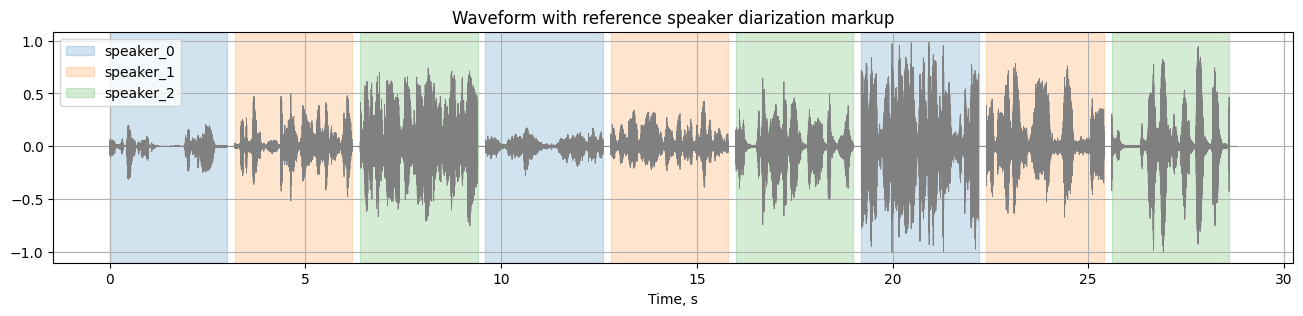

In [6]:
# Load the generated synthetic audio
waveform, sr = torchaudio.load(AUDIO_PATH)

assert sr == SAMPLE_RATE, f'Expected {SAMPLE_RATE} Hz, but selected {sr} Hz'

if waveform.size(0) > 1:
    waveform = torch.mean(waveform, dim=0, keepdim=True)

waveform = waveform.squeeze(0)
waveform = waveform/(waveform.abs().max() + 1e-9)

# Visualization of waveform and reference speaker diarization markup
if segments_ref is not None:
    times = np.arange(len(waveform)) / SAMPLE_RATE
    fig, ax = plt.subplots(figsize=(16, 3))
    ax.plot(times, waveform.numpy(), color='gray', linewidth=0.6)
    colors = {idx: item for idx, item in enumerate(mcolors.TABLEAU_COLORS)}
    for s, e, lab in segments_ref:
        ax.axvspan(s, e, color=colors.get(lab), alpha=0.2, label=f'speaker_{lab}')
    
    handles, labels_ = ax.get_legend_handles_labels()
    by_label = dict(zip(labels_, handles))
    ax.legend(by_label.values(), by_label.keys())
    ax.set_title('Waveform with reference speaker diarization markup')
    ax.set_xlabel('Time, s')
    ax.grid(True)

ipd.Audio(AUDIO_PATH)

In [7]:
# Speaker embedding extractor initialization
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using device:', device)

spk_model = MainModel(nOut=512, encoder_type='ASP', n_mels=64, log_input=True)

with open('../data/lists/models.txt', 'r') as f:
    lines = f.readlines()

spk_model = load_model(spk_model, lines, save_path='../data/models')
spk_model.to(device)
spk_model.eval();

Using device: cuda
Embedding size is 512, encoder ASP.
File baseline_v2_ap.model is downloaded.


In [8]:
# Extracting local embeddings using a sliding window
win_len = int(WINDOW_SEC*SAMPLE_RATE)
step    = int( STEP_SEC*SAMPLE_RATE)

frames = []
starts = []
for start in range(0, max(1, len(waveform) - win_len + 1), step):
    end = start + win_len
    if end > len(waveform):
        chunk = torch.zeros(win_len)
        chunk[:len(waveform) - start] = waveform[start:]
    else:
        chunk = waveform[start:end]
    
    frames.append(chunk.unsqueeze(0))          # (1, T)
    starts.append(start)

frames = torch.stack(frames, dim=0)            # (N, 1, T)
print('Total frames:', frames.shape[0])

BATCH = 64
embeds = []
with torch.no_grad():
    for i in range(0, len(frames), BATCH):
        batch = frames[i:i + BATCH].to(device)
        batch = batch.squeeze(1)               # (B, T)
        E = spk_model(batch)                   # (B, nOut)
        embeds.append(E.cpu())

embeds = torch.cat(embeds, dim=0).numpy()
print('Embedding tensor shape:', embeds.shape)

Total frames: 54
Embedding tensor shape: (54, 512)


**2.4. Кластеризация полученных локальных дикторских эмбеддингов.** На данном этапе необходимо запустить процедуру кластеризации вычисленных локальных дикторских эмбеддингов. При использовании кластеризации на основе k-средних, агломеративной иерархической кластеризации, а также спектральной кластеризации необходимо задать предполагаемое число кластеров, N_SPEAKERS, в качестве гиперпараметра. При использовании основанной на плотности пространственной кластеризация для приложений с шумами число кластеров определяется автоматически для заданных гиперпараметров DBSCAN_EPS и DBSCAN_MIN_SAMPLES в настройках выше (при проведении данной кластеризации шуму присваивается метка $-1$).

In [9]:
# Clustering of the obtained local speaker embeddings
def run_clustering(X):
    # Run clustering algorithm
    
    if CLUSTER_ALGO == 'kmeans':
        model = KMeans(n_clusters=N_SPEAKERS, random_state=0)
        labels = model.fit_predict(X)
    
    elif CLUSTER_ALGO == 'agglo':
        # The 'metric' parameter is supported in newer versions of sklearn
        try:
            model = AgglomerativeClustering(n_clusters=N_SPEAKERS, linkage='average', metric='cosine')
        except TypeError:
            model = AgglomerativeClustering(n_clusters=N_SPEAKERS, linkage='average', affinity='cosine')
        labels = model.fit_predict(X)
    
    elif CLUSTER_ALGO == 'spectral':
        model = SpectralClustering(n_clusters=N_SPEAKERS, assign_labels='kmeans', random_state=0, affinity='nearest_neighbors')
        labels = model.fit_predict(X)
    
    elif CLUSTER_ALGO == 'dbscan':
        model = DBSCAN(eps=DBSCAN_EPS, min_samples=DBSCAN_MIN_SAMPLES, metric='cosine')
        labels = model.fit_predict(X)
    
    else:
        raise ValueError('Unknown CLUSTER_ALGO')
    
    return labels

labels = run_clustering(embeds)
unique_labels = sorted(set(labels.tolist()))
print('Clusters found:', unique_labels)

Clusters found: [0, 1, 2]


**2.5. Формирование диаризационной разметки во временной области.** На данном этапе на основе кластеризационной разметки локальных дикторских эмбеддингов необходимо сформировать непрерывные временные интервалы, каждый из которых содержит речь определённого диктора, голос которого звучит в анализируемом сигнале. Для численной оценки качества полученной системной диаризационной разметки (диаризационной гипотезы) можно воспользоваться метрикой [диаризационной ошибки](https://xavieranguera.com/phdthesis/node108.html#eq_der), измеряемой в процентах. Рассматриваемая метрика является эталонной, то есть для её расчёта необходима как системная разметка диаризации, так и эталонная. Подсчёт диаризационной ошибки, в простейшем случае отсутствия наложенной речи, включает в себя вычисление трёх ошибок. Две из них, $E_{MISS}$ и $E_{FA}$, связаны с ошибками детектора речи, возникающими при пропуске речи, $E_{MISS}$, и при ложном её детектировании, $E_{FA}$. Третья ошибка, $E_{spkr}$, связана с неверно назначенной речевому сегменту меткой диктора. Итоговая формула для вычисления ошибки диаризации выглядит следующим образом: $DER = E_{MISS} + E_{FA} + E_{spkr}$. Для расчёта диаризационной ошибки можно воспользоваться Python-модулем [dscore](https://github.com/nryant/dscore).

0.00-3.25s 	 speaker_0
3.25-5.75s 	 speaker_1
5.75-9.75s 	 speaker_2
9.75-12.75s 	 speaker_0
12.75-16.25s 	 speaker_1
16.25-18.75s 	 speaker_2
18.75-22.25s 	 speaker_0
22.25-25.75s 	 speaker_1
25.75-28.50s 	 speaker_2
Total number of segments: 9


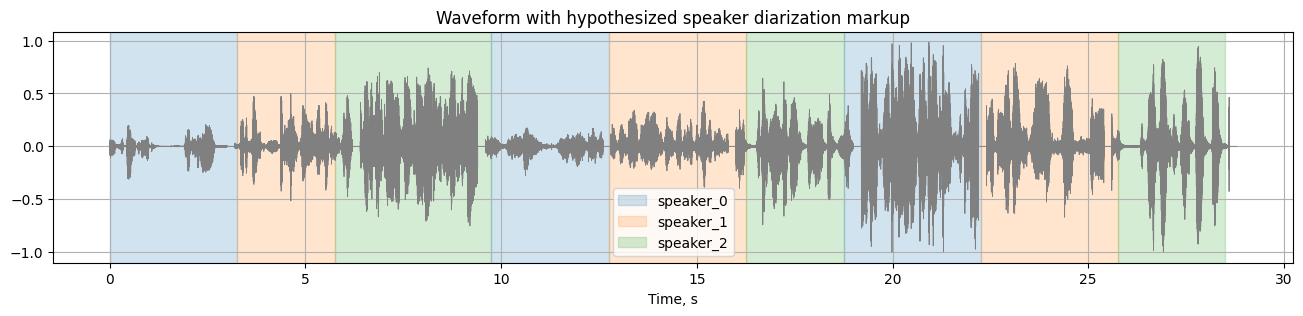

In [10]:
def merge_labels_to_segments(labels, starts, win_len, sr):
    # Generation of diarization markup in the time domain
    
    segs = []
    if len(labels) == 0:
        
        return segs
    
    cur_lab = int(labels[0])
    cur_start = starts[0]
    for i in range(1, len(labels)):
        if int(labels[i]) != cur_lab:
            segs.append((cur_start/sr, (starts[i-1] + win_len)/sr, cur_lab))
            cur_lab = int(labels[i])
            cur_start = starts[i]
    
    segs.append((cur_start/sr, (starts[-1] + win_len)/sr, cur_lab))
    
    for idx in range(len(segs) - 1):
        segs[idx], segs[idx + 1] = (segs[idx][0], (segs[idx][1] + segs[idx + 1][0])/2, segs[idx][2]), \
                                   ((segs[idx][1] + segs[idx + 1][0])/2, segs[idx + 1][1], segs[idx + 1][2])
    
    return segs

# Generate hypothesis diarization markup
segments_hyp = merge_labels_to_segments(labels, starts, win_len, SAMPLE_RATE)
for s, e, lab in segments_hyp:
    print(f'{s:.2f}-{e:.2f}s \t speaker_{lab}')

print('Total number of segments:', len(segments_hyp))

# Visualization of waveform and hypothesis diarization markup
times = np.arange(len(waveform))/SAMPLE_RATE
fig, ax = plt.subplots(figsize=(16, 3))
ax.plot(times, waveform.numpy(), color='gray', linewidth=0.6)
colors = {idx: item for idx, item in enumerate(mcolors.TABLEAU_COLORS)}
for s, e, lab in segments_hyp:
    ax.axvspan(s, e, color=colors.get(lab, 'tab:green'), alpha=0.2, label=f'speaker_{lab}')

handles, labels_ = ax.get_legend_handles_labels()
by_label = dict(zip(labels_, handles))
ax.legend(by_label.values(), by_label.keys())
ax.set_title('Waveform with hypothesized speaker diarization markup')
ax.set_xlabel('Time, s')
ax.grid(True)

In [11]:
# Generating RTTM file with hypothesis diarization markup
rec_id = os.path.splitext(os.path.basename(AUDIO_PATH))[0]
rttm_lines = []
for s, e, lab in segments_hyp:
    dur = max(0.0, e - s)
    rttm_lines.append(f'SPEAKER {rec_id} 1 {s:.3f} {dur:.3f} <NA> <NA> speaker_{lab} <NA> <NA>')

with open(AUDIO_PATH.replace('.wav', '_hyp.rttm'), 'w') as f:
    f.write('\n'.join(rttm_lines))

In [12]:
# Compute Diarization Error Rate
!python score.py -r ./synth_audio_example/synth_audio_ref.rttm -s ./synth_audio_example/synth_audio_hyp.rttm

Loading speaker turns from reference RTTMs...
Loading speaker turns from system RTTMs...
Trimming reference speaker turns to UEM scoring regions...
Trimming system speaker turns to UEM scoring regions...
Checking for overlapping reference speaker turns...
Checking for overlapping system speaker turns...
Scoring...
File               DER
---------------  -----
synth_audio      11.11
*** OVERALL ***  11.11


**3. Задания для самостоятельного выполнения**

В рамках настоящей лабораторной работы не требуется завершать заготовки программных кодов. Основная задача состоит в том, чтобы провести ряд экспериментов с уже готовым алгоритмом дикторской диаризации:

1. Выполните запуск алгоритма с настройками по умолчанию.

2. Оцените влияние размера оконной функции и её сдвига на качество работы алгоритма.

3. Изучите влияние количества дикторов в синтезированной звукозаписи на качество работы алгоритма.

4. Проверьте влияние различных алгоритмов кластеризации и их настроек на качество работы алгоритма.

5. Замените экстрактор дикторских эмбеддингов, используемый по умолчанию, на его версию, полученную в рамках лабораторной работы №3, и оцените качество работы алгоритма.

**4. Контрольные вопросы**

1. Что такое дикторская диаризация?

2. Как выглядит классическая схема конвейера дикторской диаризации?

3. Что такое локальные дикторские эмбеддинги?

4. Какие алгоритмы кластеризации вам известны и в чём отличие их использования в задаче дикторской диаризации?

5. Как выглядит процедура формирования диаризационной разметки во временной области по результатам кластеризации локальных дикторских эмбеддингов?

**5. Список литературы**

1. Park T.J. et al. A review of speaker diarization: recent advances with deep learning // 	arXiv:2101.09624 [eess.AS] ([ссылка](https://arxiv.org/pdf/2101.09624)).

2. Snyder D. et al. Speaker recognition for multi-speaker conversations using x-vectors // Proc. 2019 IEEE Int. Conf. Acoustics, Speech and Signal Processing (ICASSP), 2019. P. 5796–5800 ([ссылка](https://www.danielpovey.com/files/2019_icassp_multi_speaker.pdf)).